In [1]:
from pathlib import Path
import hydra_zen
from omegaconf import OmegaConf 
import torch
import xarray as xr
import lightning as L
import numpy as np
import importlib
import matplotlib.pyplot as plt
import glob
from data_module import WindDirectionDataModule
import simple_conv
importlib.reload(simple_conv)
from simple_conv import MyModel
import math

# Use function

In [2]:
def load_model(model_path, inc, hid, depth, model_mdn=True, down=4, weight_decay=None, num_gaussians=2, data_augmentation=False):
    checkpoint = torch.load(model_path)
    model = MyModel(inc=inc, hid=hid, depth=depth, model_mdn=model_mdn, down=down, weight_decay=weight_decay, num_gaussians=num_gaussians, data_augmentation=data_augmentation)
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint


def load_data(path, checkpoint, inc=2):
    data_module = WindDirectionDataModule(test_data_paths=path, inc=inc)
    data_module.train_mean = checkpoint['train_mean']
    data_module.train_std = checkpoint['train_std']
    data_module.setup(stage='predict')
    dataloader = data_module.test_dataloader()
    return dataloader, data_module


def predict(model, dataloader, model_mdn=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    y_pred = []
    uncertainty = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            X, _ = batch
            X = X.to(device)
            
            if model_mdn:
                preds, uncer = model(X)
                y_pred.append(preds)
                uncertainty.append(uncer)
            else:
                preds = model(X)
                y_pred.append(preds)
        y_pred = torch.concat(y_pred).cpu()
        
        if model_mdn:
            uncertainty = torch.cat(uncertainty, dim=0).cpu()
            return y_pred.squeeze(), uncertainty
        
        return y_pred.squeeze()
        

def loss_cos(y_true, y_pred, ambi=False):
    err = y_pred - y_true
    if not ambi:
        err = err / 2
    loss = 1 - torch.square(torch.cos(err))
    return torch.mean(loss)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

def get_histogram_2d_variables(x_column, y_column, nbins=100):
    x_min, x_max = np.min(x_column), np.max(x_column)
    y_min, y_max = np.min(y_column), np.max(y_column)
    
    kernel = stats.gaussian_kde([x_column, y_column])
    xi, yi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j]
    zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        
    return xi, yi, zi.reshape(xi.shape)

def hist2d_prediction_vs_reference(x, y, pred_std, pol, title, mod=False, mission='S1'):
    X, Y, Z = get_histogram_2d_variables(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=(6, 1), height_ratios=(1, 6),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
        
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
        
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.pcolormesh(X, Y, Z, shading='auto', cmap='Blues')
    ax.set_xlabel('Reference angle (°)', fontsize=14)
    ax.set_ylabel('Predicted angle (°)', fontsize=14)
    ax.set_xlim(0, 180)
    ax.set_ylim(0, 180)
    
    nbins = 90
    binwidth = 180 / nbins

    bins = np.arange(0, 180 + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, alpha=0.75)
    ax_histx.grid(linestyle='--', color='gray', alpha=0.9)
    ax_histx.set_xlim(0, 180)
    ax_histy.hist(y, bins=bins, orientation='horizontal', alpha=0.75)
    ax_histy.grid(linestyle='--', color='gray', alpha=0.9)
    ax_histy.set_ylim(0, 180)

    ax.grid(linestyle='--', color='gray', alpha=0.9)
    
    x_series = pd.Series(x)
    y_series = pd.Series(y)
    
    diff_serie = (y_series - x_series % 180).apply(lambda v: -1 * np.sign(v) * 180 + v if np.abs(v) > 90 else v)
    bias = diff_serie.mean()
    std = diff_serie.std()
    nb_points = len(x)

    txt_str = 'Number of points: %d \nBias: %.2f° | Std: %.2f°' % (nb_points, bias, std)
    if pred_std:
        title_str = f'{mission} ({pol}) predicted angle & hy2b angle\nDiff_time_max: 30min, STD predicted: [0 - {pred_std.values.max():.2f}]°'
    else:
        if mod:
            title_str = f'{mission} ({pol}) predicted angle & hy2b angle\nDiff_time_max: 30min {title} mod90'
            
        else:
            title_str = f'{mission} ({pol}) predicted angle & hy2b angle\nDiff_time_max: 30min {title}'
    props = dict(boxstyle='square', facecolor='white')
        
    ax.text(0.05, 0.95, txt_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.plot([0, 180], [0, 180], color='k', linestyle='--')
    plt.suptitle(title_str, fontsize=20)
        
    plt.show()


In [5]:
# mod = '2024-08-30/10-04-59/0/wind_direction_model/2_4_128_7_True_0.0001_True_ren_ds'
mod = '2024-09-24/13-55-35/0/wind_direction_model/1_4_128_5_False_0.0001_True_True_ren_ds'
model_old = f'/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/{mod}/checkpoints/best-checkpoint.ckpt'
inc = 1
model_mdn = False
weight_decay = 1e-4
model, checkpoint = load_model(model_path=model_old, inc=inc, hid=128, depth=5, model_mdn=model_mdn, down=4, weight_decay=weight_decay, num_gaussians=2, data_augmentation=True)


# Renaud ds

In [6]:
# ds_path_train = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset_180/train_dataset_norm.nc"

ds_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset_180/test_dataset_norm.nc"

In [7]:
dataloader, data_module = load_data(path=ds_path, checkpoint=checkpoint, inc=inc)

In [11]:
dataloader, data_module = load_data(path=ds_path, checkpoint=checkpoint, inc=inc)
if model_mdn:
    y_pred, uncertainty = predict(model, dataloader, model_mdn=model_mdn)
else:
    y_pred = predict(model, dataloader, model_mdn=model_mdn)


In [12]:
tst_ds = xr.open_dataset(ds_path)
heading_angles = tst_ds.sel(pol='VV').ground_heading.values[:,0,0]
y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles)%180
y_hy2b = tst_ds.sel(pol='VV').hy2b_wind_direction.values
y_pred_rob = tst_ds.sel(pol='VV').mean_wind_direction.values

In [ ]:
# y_pred_norm, y_hy2b, y_pred_rob = get_val(ds_path, y_pred)

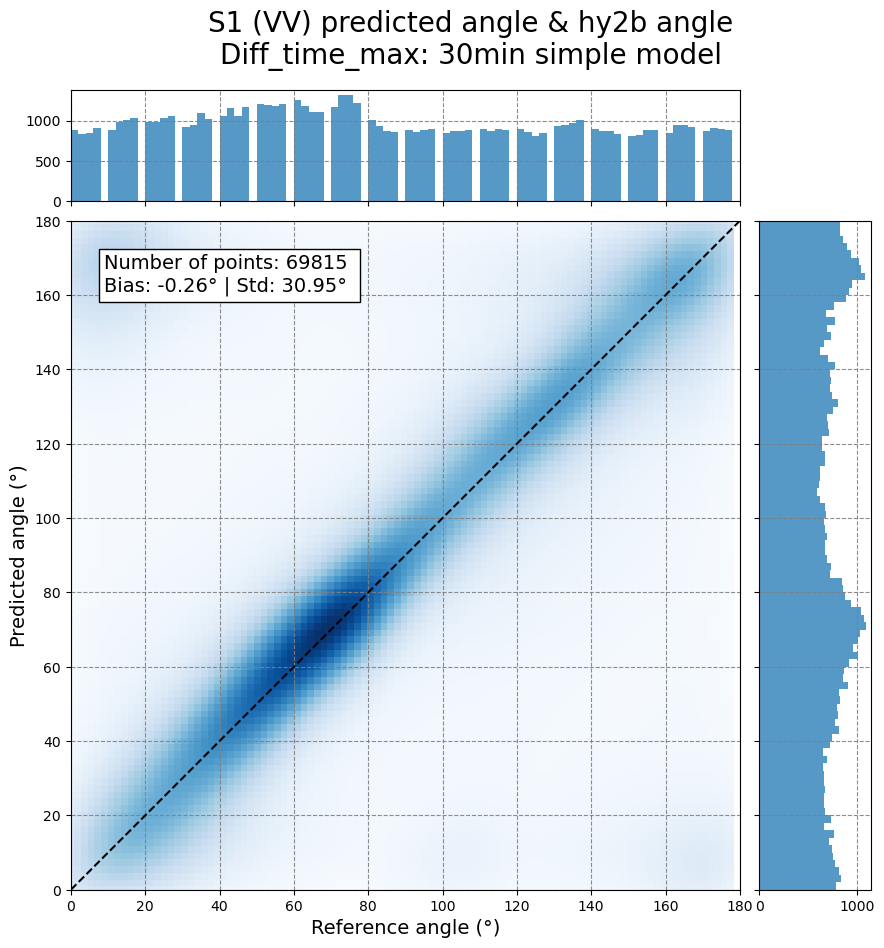

In [13]:
pol = 'VV' if inc == 1 else 'VV-VH'
hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=y_pred_norm, pred_std=None, title='simple model', pol=pol)

In [ ]:
# hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=np.array(y_pred_rob%180), pred_std=None, title='Robin Model', pol='VV')

In [ ]:
y_true = torch.tensor(np.deg2rad(y_hy2b%180), dtype=torch.float32)
y_pred = torch.tensor(np.deg2rad(y_pred_norm%180), dtype=torch.float32)

test_loss = loss_cos(y_true, y_pred)
print(test_loss)

In [ ]:
err = np.deg2rad(5)
print(math.cos(err))
loss = 1 - abs(math.cos(err))
loss

In [ ]:
print(math.sin(err))
loss = abs(math.sin(err))
loss

In [ ]:
err = np.deg2rad(90)
err

In [ ]:
- 0.5 * (1-math.cos(err/0.2))**2

In [ ]:
path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset/test_robin.nc"
dataloader, data_module = load_data(path=path, checkpoint=checkpoint, inc=1)
y_pred= predict(model, dataloader)
y_pred, uncertainty, all_pi, all_mu, all_sigma = predict(model, dataloader)


In [ ]:
ds = xr.open_dataset(path)
ds

In [ ]:
heading_angles = ds.sel(pol='VV').ground_heading.values[:,0,0]
y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles)%180
y_hy2b = ds.sel(pol='VV').hy2b_wind_direction.values

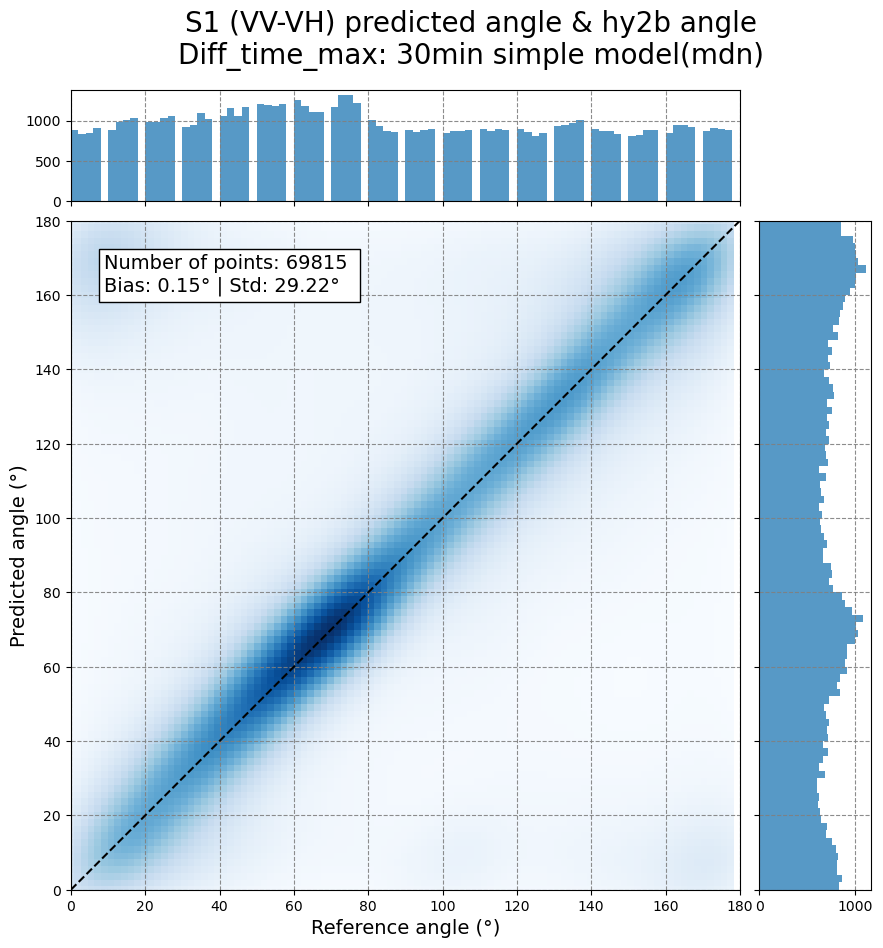

In [8]:
hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=y_pred_norm, pred_std=None, title='simple model(mdn)', pol='VV-VH')

In [9]:
unc = (np.rad2deg(uncertainty.squeeze()))%180

/tmp/ipykernel_1306278/3475116999.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  unc = (np.rad2deg(uncertainty.squeeze()))%180


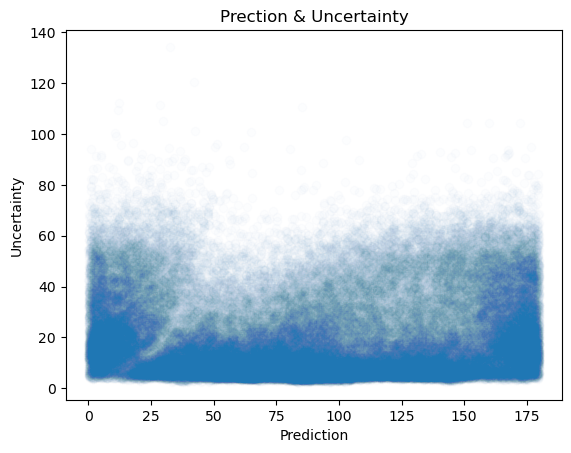

In [10]:
plt.scatter(np.rad2deg(np.array(y_pred))%180, unc, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Uncertainty')
plt.title('Prection & Uncertainty')
plt.show()

In [11]:
df = pd.DataFrame({
    'y_true' : y_hy2b,
    'y_pred_norm_128': y_pred_norm,
    'uncertainty_128': unc
})

In [12]:
df = pd.read_csv('./df_pred.csv')

In [14]:
df['y_pred_norm_256'] = y_pred_norm
df['uncertainty_256'] = unc

In [31]:
ds.mean_wind_direction.values

array([[  3.43474922,  10.32603247,  12.60481569, ..., 165.76258814,
        158.74162096, 158.66630201],
       [  8.42555535,   7.24599613,  17.20767415, ...,  41.44067447,
          8.97840642,  15.5978398 ]])

In [32]:
df['y_pred_rob_vv'] = ds.sel(pol='VV').mean_wind_direction.values
df['y_pred_rob_vh'] = ds.sel(pol='VH').mean_wind_direction.values

In [33]:
df.to_csv('./df_pred.csv', index=False)

In [18]:
df_40 = df[df['uncertainty']<10]

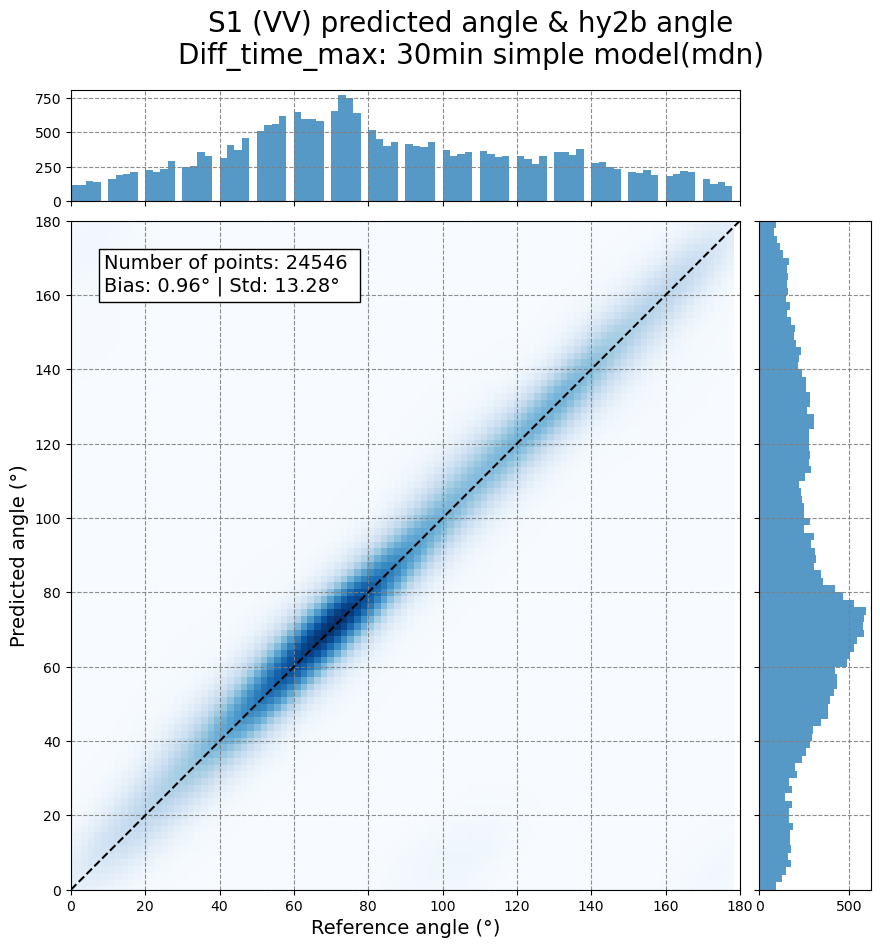

In [21]:
hist2d_prediction_vs_reference(x=np.array(df_40['y_true'])%180, y=np.array(df_40['y_pred_norm'])%180, pred_std=None, title='simple model(mdn)', pol='VV', mission='S1')

In [17]:
def uncert(df, hid):
    uncert_val = []
    # point_num = []
    point_percent = []
    
    total_points = len(df)
    for i in range(5, 45, 5):  
        df_filt = df[df[f'uncertainty_{hid}'] < i] 
        uncert_val.append(i)
        
        num_points = len(df_filt)  
        # point_num.append(num_points)
        
        percent_points = (num_points / total_points)   
        point_percent.append(percent_points)
    return uncert_val, point_percent

In [18]:
uncert_val_128, point_percent_128 = uncert(df, hid='128')

In [19]:
uncert_val_256, point_percent_256 = uncert(df, hid='256')


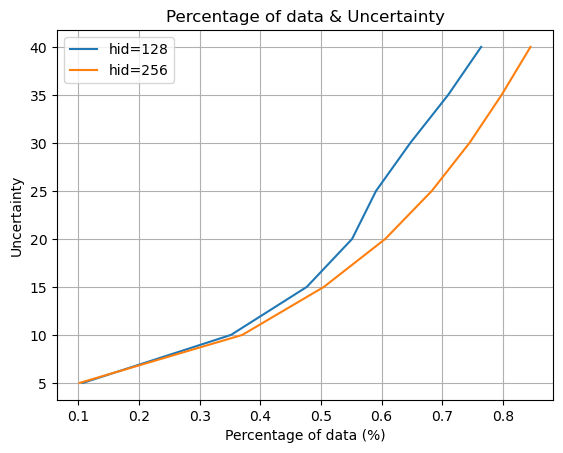

In [21]:
plt.plot(point_percent_128, uncert_val_128, label='hid=128')
plt.plot(point_percent_256, uncert_val_256, label='hid=256')

plt.xlabel('Percentage of data (%)')
plt.ylabel('Uncertainty')
plt.title('Percentage of data & Uncertainty')
plt.legend()
plt.grid()
plt.show()

In [79]:
theta_dif_rob = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_rob_vv'])%180
theta_dif_128 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_128'])%180
theta_dif_256 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_256'])%180

In [80]:
df

,y_true,y_pred_norm_128,uncertainty_128,y_pred_norm_256,uncertainty_256,y_pred_rob_vv,y_pred_rob_vh
0,180.0,0.959656,5.813537,179.120132,4.826562,3.434749,8.425555
1,185.0,10.311569,3.838064,11.877655,4.193725,10.326032,7.245996
2,200.0,16.825623,4.994570,13.331024,3.872831,12.604816,17.207674
3,220.0,19.175370,38.678997,13.515350,19.768755,68.139045,59.846954
4,240.0,122.419464,53.472800,117.164017,11.547165,11.775301,19.405392
...,...,...,...,...,...,...,...
69810,7.5,15.308716,39.526104,4.503963,16.367115,178.230863,160.909899
69811,5.0,171.744110,21.779585,172.877960,17.377426,168.370758,14.984333
69812,2.5,174.295060,27.181992,165.995361,18.021669,165.762588,41.440674
69813,357.5,169.082700,13.807508,163.083771,10.930461,158.741621,8.978406


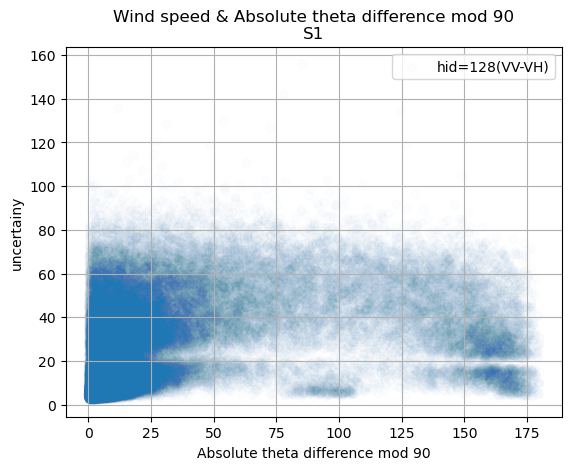

In [87]:
plt.scatter(theta_dif_128, df['uncertainty_128'], label='hid=128(VV-VH)', alpha=0.01)
# plt.scatter(df['uncertainty_256'], theta_dif_256, label='hid=256(VV-VH)')

plt.xlabel('Absolute theta difference mod 90')
plt.ylabel('uncertainy')
plt.title('Wind speed & Absolute theta difference mod 90\nS1')
plt.grid()
# plt.xlim(0,35)
# plt.ylim(0, 90)
plt.legend()
plt.show()

In [44]:
def get_fit_function(sig, theta_dif, coef, coef_name='.', mod=False, p=8):
    res = np.zeros_like(sig, dtype=float)
    if coef_name == 'sig0_detr':
        coef_val = 10*np.log10(coef)
    else:
        coef_val = coef
    if mod:
        theta_mod = theta_dif % 90
    else:
        theta_mod = theta_dif
    for cpt, _sig in enumerate(sig):
        cond = np.abs(coef_val - _sig) < 2.5
        if np.any(cond):
            res[cpt] = np.mean(np.array(theta_mod)[cond])
        else:
            res[cpt] = np.nan
            
    return np.polyfit(sig, res, p), res
    

def plot_theta_difference(data_x, theta_dif, sig, res, fit_params, mission, pol, plot_type='wind_speed', mod=False, a=0.01):

    if plot_type == 'sigma0_detrend':
        log_sig = 10 * np.log10(data_x)
        x_label = 'Log mean sigma0 detrend (dB)'
        title_suffix = 'log mean sigma0 detrend'
        x_data = log_sig
    elif plot_type == 'wind_speed':
        x_label = 'Wind speed m/s'
        title_suffix = 'wind speed'
        x_data = data_x
    else:
        raise ValueError("Invalid plot_type. Choose 'wind_speed' or 'sigma0_detrend'.")

    if mod:
        plt.plot(x_data, theta_dif % 90, 's', alpha=a)
        y_label = 'Absolute theta difference mod 90(simple_conv)'
    else:
        plt.plot(x_data, theta_dif, 's', alpha=a)
        y_label = 'Absolute theta difference'

    plt.plot(sig, res, 'r', lw=3, label='Mean absolute theta difference')

    get_abs_theta_dif = np.poly1d(fit_params)

    t = np.linspace(min(sig), max(sig), 100)
    plt.plot(t, get_abs_theta_dif(t), "--b", label="Fit function", lw=1.5)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{y_label} vs {title_suffix} \n{mission}({pol})')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return get_abs_theta_dif

def theta_dif_prediction(df_upol, sig, get_abs_theta_dif, coef_name='.'):
    if coef_name == 'sig0_detr':
        in_val = 10 * np.log10(df_upol['sig0_detr_mean'].values)
    else:
        in_val = df_upol['hy2b_wind_speed'].values
        
    in_val = np.clip(in_val, sig.min(), sig.max())
    in_val = np.nan_to_num(in_val, nan=-40)
    pred_abs_theta_dif = get_abs_theta_dif(in_val)
    
    if coef_name == 'sig0_detr':
        df_upol['theta_dif_sig0_detr'] = pred_abs_theta_dif
    else:
        df_upol['theta_dif_wspeed'] = pred_abs_theta_dif

    
    return df_upol

In [42]:
wind_speed = np.array(ds['hy2b_wind_speed'].values)
# theta_dif = abs(tst_ds.hy2b_wind_direction.values - ds.sel(pol=pol).mean_wind_direction.values)%180

In [73]:
theta_dif_rob = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_rob_vv'])%180
theta_dif_128 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_128'])%180
theta_dif_256 = abs((ds.hy2b_wind_direction.values)%180 - df['y_pred_norm_256'])%180



In [46]:
sig = np.arange(0, 30, 1)
mod = True
wspd_params, res = get_fit_function(sig=sig, theta_dif=theta_dif, coef=wind_speed, mod=mod)
wspd_params

array([ 1.63871859e-08, -2.24823552e-06,  1.18169213e-04, -3.02837930e-03,
        3.87717127e-02, -2.09006592e-01,  9.70959454e-02, -6.53286430e-01,
        3.62982803e+01])

In [74]:
wspd_params, res_rob = get_fit_function(sig=sig, theta_dif=theta_dif_rob, coef=wind_speed, mod=mod)
wspd_params, res_128 = get_fit_function(sig=sig, theta_dif=theta_dif_128, coef=wind_speed, mod=mod)
wspd_params, res_256 = get_fit_function(sig=sig, theta_dif=theta_dif_256, coef=wind_speed, mod=mod)



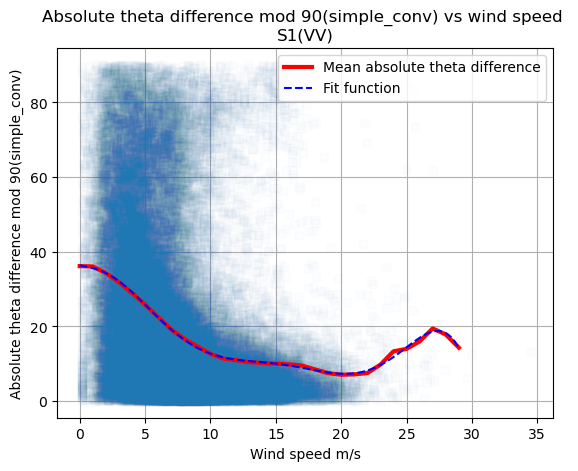

In [47]:
mission = 'S1'
pol = 'VV'
get_abs_theta_dif = plot_theta_difference(data_x=wind_speed, theta_dif=theta_dif, sig=sig, res=res, fit_params=wspd_params, mission=mission, 
                                          pol=pol, plot_type='wind_speed', mod=mod)

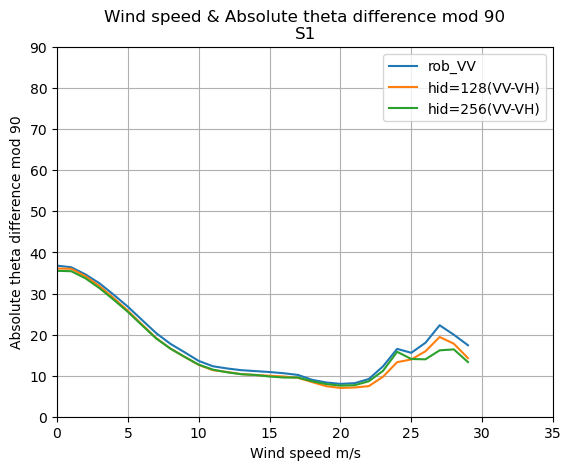

In [77]:
plt.plot(sig, res_rob, label='rob_VV')
plt.plot(sig, res_128, label='hid=128(VV-VH)')
plt.plot(sig, res_256, label='hid=256(VV-VH)')

plt.xlabel('Wind speed m/s')
plt.ylabel('Absolute theta difference mod 90')
plt.title('Wind speed & Absolute theta difference mod 90\nS1')
plt.grid()
plt.xlim(0,35)
plt.ylim(0, 90)
plt.legend()
plt.show()

# Robin ds

In [12]:
ds_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset/test_robin.nc"
dataloader, data_module = load_data(path=ds_path, checkpoint=checkpoint, inc=inc)
y_pred = predict(model, dataloader, model_mdn=False)
# y_pred, uncertainty = predict(model, dataloader, model_mdn=True)


AssertionError: Size mismatch between tensors

In [ ]:
ds = xr.open_dataset(ds_path)

In [ ]:
y_era5 = (ds.sel(pol='VV').era5_angle.values)%180
heading_angles = ds.sel(pol='VV').ground_heading.values
y_pred_norm = np.add(np.rad2deg(np.array(y_pred)), heading_angles)%180

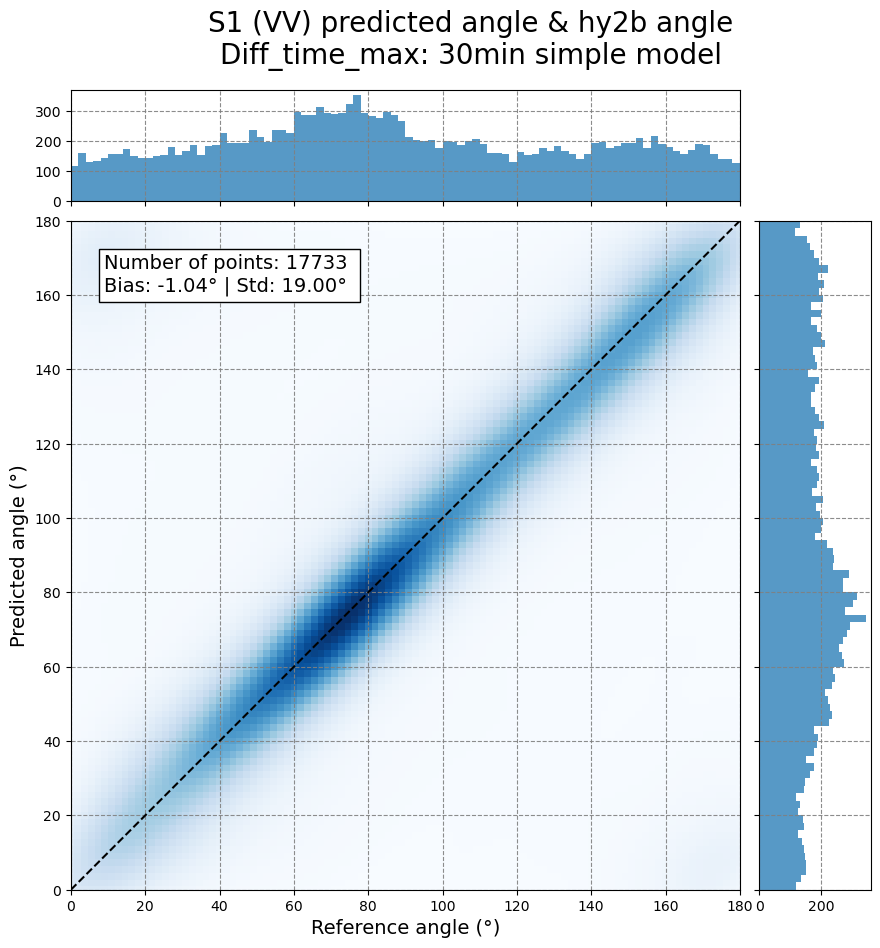

In [18]:
hist2d_prediction_vs_reference(x=y_era5, y=y_pred_norm, pred_std=None, title='simple model', pol='VV')

In [19]:
y_pred = ds.sel(pol='VV').pred_angle.values%180
# hist2d_prediction_vs_reference(x=y_era5, y=y_pred, pred_std=None, title='Robin model', pol='VV')

In [20]:
df_test = pd.DataFrame({
    'reference_angle' : y_era5,
    'Robin_pred' : y_pred,
    'Simple_model' : y_pred_norm
})

y_true = torch.tensor(np.deg2rad(df_test['reference_angle'].values), dtype=torch.float32)
y_pred_rob = torch.tensor(np.deg2rad(df_test['Robin_pred'].values), dtype=torch.float32)

rob_test_loss = loss_cos(y_true, y_pred_rob)

y_pred_ren = torch.tensor(np.deg2rad(df_test['Simple_model'].values), dtype=torch.float32)

ren_test_loss = loss_cos(y_true, y_pred_ren)
print(f"Robin loss:{rob_test_loss}\nRenaud loss:{ren_test_loss}")

Robin loss:0.07488402724266052
Renaud loss:0.07365257292985916
